In [1]:
###### Packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy
import skimage
import scipy.ndimage
from skimage.util import montage
from skimage import exposure
from skimage import measure
import seaborn as sns
import pandas as pd
import math
import sys
import random
import imutils
import mahotas as mt
import fil_finder

In [201]:
import os
import random
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt

# Data Preprocessing
def read_images(image_path, cellline_string, norm=True, verbose=True):
    images, filelist, cellline, timepoint, exp = [], [], [], [], []
    
    subfolder_path = os.path.join(image_path, cellline_string)

    if not cellline_string or not os.path.exists(subfolder_path):
        print(f'Subfolder "{cellline_string}" not found.')
        print(f'Number of images:', 0)
        return filelist, images, cellline, exp, timepoint
    
    for subdir, dirs, files in os.walk(os.path.join(image_path, cellline_string)):
        if subdir == subfolder_path: 
            for file in sorted(files):
                filepath = subdir + os.sep + file
                filepath = filepath.replace("\\", "/")

                if filepath.endswith(".tif"):
                    im = cv2.imread(filepath, -1)

                    if im is not None and im.shape == (crop_size[0], crop_size[1]):
                        if norm:
                            rescale2 = exposure.rescale_intensity(im)
                            rescale2 = exposure.equalize_adapthist(rescale2)
                            images.append(np.asarray(rescale2))
                        else:
                            images.append(np.asarray(im))

                        name = filepath.rsplit('/', 1)[-1]
                        time = name.rsplit('_')[-3]
                        cellline.append(cellline_string)
                        filelist.append(name)
                        timepoint.append(time)
                        exp.append(name.rsplit("_")[1])

    images = np.array(images)
    
    if verbose:
        print(f'Number of images in {cellline_string}:', images.shape[0])
    
    return filelist, images, cellline, exp, timepoint

'Function to downsample classes'
def downsampling(pos, ctr, pos_list, ctr_list, pos_cellline, ctr_cellline, verbose=True):
    if pos.shape[0] < ctr.shape[0]:
        minor_n = pos.shape[0]
        major_n = ctr.shape[0]
        print('Unbalanced classes')
        print('positive (minority): %d' % minor_n)
        print('control (majority): %d' % major_n)
        
        idx = random.sample(range(1, major_n), minor_n)
        ctr = ctr[idx]
        ctr_list = np.take(ctr_list, idx)
        ctr_cellline = np.take(ctr_cellline, idx)
    else:
        minor_n = ctr.shape[0]
        major_n = pos.shape[0]
        print('Unbalanced classes')
        print('control (minority): %d' % minor_n)
        print('positve (majority): %d' % major_n)
        
        idx = random.sample(range(1, major_n), minor_n)
        pos = pos[idx]
        pos_list = np.take(pos_list, idx)
        pos_cellline = np.take(pos_cellline, idx)
    
    print('Balanced classes')
    print('Class 1 count: %d' % ctr.shape[0])
    print('Class 2 count: %d' % pos.shape[0])

    return pos, ctr, pos_list, ctr_list, pos_cellline, ctr_cellline

# Plotting
def class_montage(imgs, w, h, rescale=True):
    plt.figure(figsize=(w, h))
    plt.imshow(montage(np.array(imgs), rescale_intensity=rescale), cmap=plt.cm.gray)
    
def display_montage(images, title):
    print(f"{title} montage images")
    class_montage(images, 40, 30, rescale=True)
    
def show_3_plot(img, sec,sec_string,third,third_string):
    fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Image')

    ax[1].imshow(sec, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title(sec_string)

    ax[2].imshow(third, cmap=plt.cm.gray)
    ax[2].axis('off')
    ax[2].set_title(third_string)

    fig.tight_layout()
    plt.show()
    
def show_2_plot(img, sec,sec_string):
    fig, axes = plt.subplots(ncols=2, figsize=(8, 2.5))
    ax = axes.ravel()
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].axis('off')
    ax[0].set_title('Image')

    ax[1].imshow(sec, cmap=plt.cm.gray)
    ax[1].axis('off')
    ax[1].set_title(sec_string)
    
    fig.tight_layout()
    plt.show()
    
def show_example_crop(combine, M,N, index):
    plt.figure(figsize=(5, 5))
    plt.imshow(combine[index][0].reshape(M,N), cmap='gray')
    plt.title(f'Class: {combine[index][2]}, Cell Line: {combine[index][3]}, Experiment: {combine[index][4]}')
    plt.axis('off')
    plt.show()

In [2]:
pwd()

'Z:\\StephanieLam\\Cortical\\FeatureAnalysis\\COR37-GEDI\\ObjectCropsFilteredSorted'

# --------------------------------- User Input ---------------------------------
- image path: folder contain all images
- ctr_folder: control subfolder's string
- dis_folder: disease subfolder's string
- set downsample = True if want to balance data
- crop_size = images crop size

In [150]:
#Enter input path 
image_path ="/Users/slam/Dropbox (Gladstone)/CODE_Shared/NucleiML/TestingImages/"
#Enter Control subfolder, leave blank as ctr_folder = "" if do not have one
ctr_folder = "20CAG"
#Enter Disease subfolder, leave blank as dis_folder = "" if do not have one
dis_folder = ""
#balance data; set downsample as True, otherwise False
downsample = False
crop_size = (300,300)

Number of Disease images
Subfolder "" not found.
Number of images: 0
Number of Control images
Number of images in 20CAG: 9
Control montage images


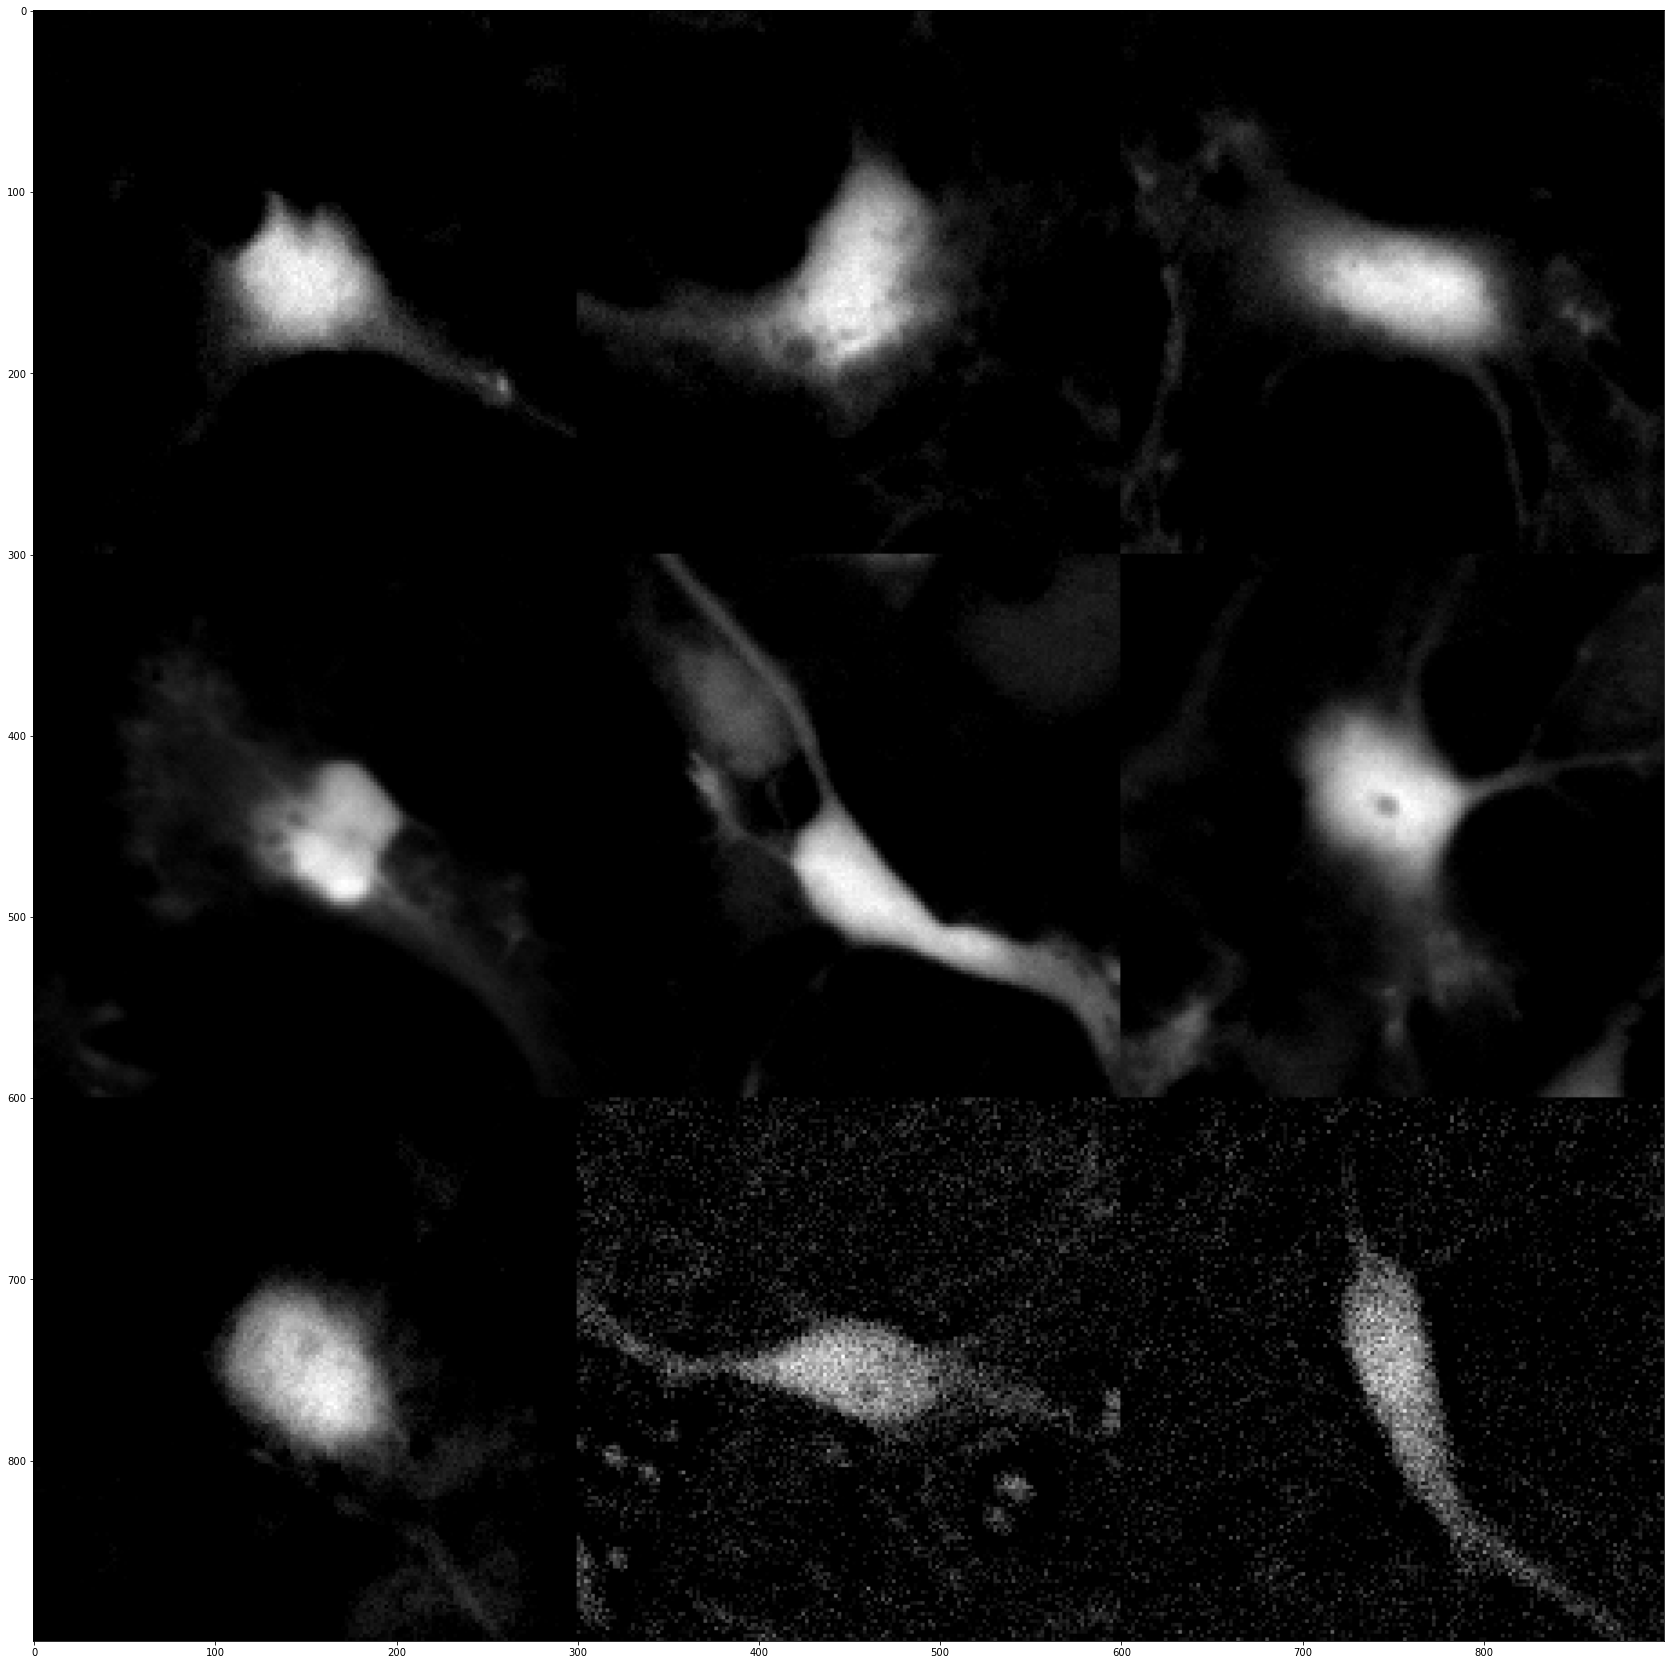

In [172]:
print('Number of Disease images')
pos_filelist, pos_img, pos_cellline, pos_exp, pos_tp = read_images(image_path, dis_folder, norm=False)
print('Number of Control images')
ctr_filelist, ctr_img, ctr_cellline, ctr_exp, ctr_tp = read_images(image_path, ctr_folder, norm=False)

if dis_folder:
    display_montage(pos_img, "Disease")

if ctr_folder:
    display_montage(ctr_img, "Control")

In [173]:
if downsample:
    pos_img, ctr_img, pos_filelist, ctr_filelist, pos_cellline, ctr_cellline = downsampling(
        pos_img, ctr_img, pos_filelist, ctr_filelist, pos_cellline, ctr_cellline)

# Store cell basic information into tuples
pos_tuple = tuple(zip(pos_img, pos_filelist, [1] * len(pos_filelist), pos_cellline, pos_exp))
ctr_tuple = tuple(zip(ctr_img, ctr_filelist, [0] * len(ctr_filelist), ctr_cellline, ctr_exp))

combine = pos_tuple + ctr_tuple

M = crop_size[0]
N = crop_size[1]

-------------- Printing example data ----------------- 
original images [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
images PID20200528_JAK200519-COR16-P1-GFP-HttDye_T2_0-1_A01_0_FITC_0_1_0_BGpbs_MN_1034.tif
class 0
cell line 20CAG
experiment JAK200519-COR16-P1-GFP-HttDye


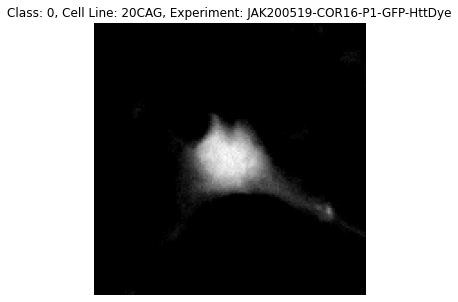

In [174]:
print('-------------- Printing example data ----------------- ')

example_index = 0  # Change this index to print different examples

# Print example data
print('original images', combine[example_index][0])
print('images', combine[example_index][1])
print('class', combine[example_index][2])
print('cell line', combine[example_index][3])
print('experiment', combine[example_index][4])

# Show example crop
show_example_crop(combine, M, N,example_index)

## ----------------------------------- Image Features ----------------------------------

## Soma Feature
- using median blur and basic thresholding to capture soma area

Returns:

* soma_med: pixel median of the captured soma
* soma_skew: pixel skewness of the captured soma
* soma_area: total pixel area of the captured soma

In [184]:
from scipy import misc
from scipy.stats import kurtosis
from scipy.stats import skew

def soma_extract(data, thresh, plot_graph=True):
    cell_img, features_e, features_area, features_median, features_skew, filter_list = [], [], [], [], [], []

    for i in range(len(data)):
        img = data[i][0].reshape(M, N)
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        blur = cv2.medianBlur(img, 9)
        segment = blur > thresh

        labeled_array, num_features = scipy.ndimage.measurements.label(segment)

        # Find the maximum area among regions
        if num_features > 0:
            regions = skimage.measure.regionprops(labeled_array)
            max_area = max(props.area for props in regions)
            features_area.append(max_area)
        
        # Append to the filter list if no features are found
        else:
            features_area.append(0)
            filter_list.append(data[i][1])

        if max_area > 15000:
            filter_list.append(data[i][1])
            if plot_graph:
                show_3_plot(img, blur, 'MedianBlur', segment, "Segmentation")

        cell_img.append(segment)
        features_median.append(np.median(img))
        features_skew.append(np.mean(skew(img)))

    return cell_img, features_median, features_skew, features_area, filter_list

In [185]:
'Soma Extraction - segmentation of soma only'
soma_img, soma_med, soma_skew, soma_area, soma_filter_list = soma_extract(combine,thresh=150, plot_graph=False)

control soma segmented images


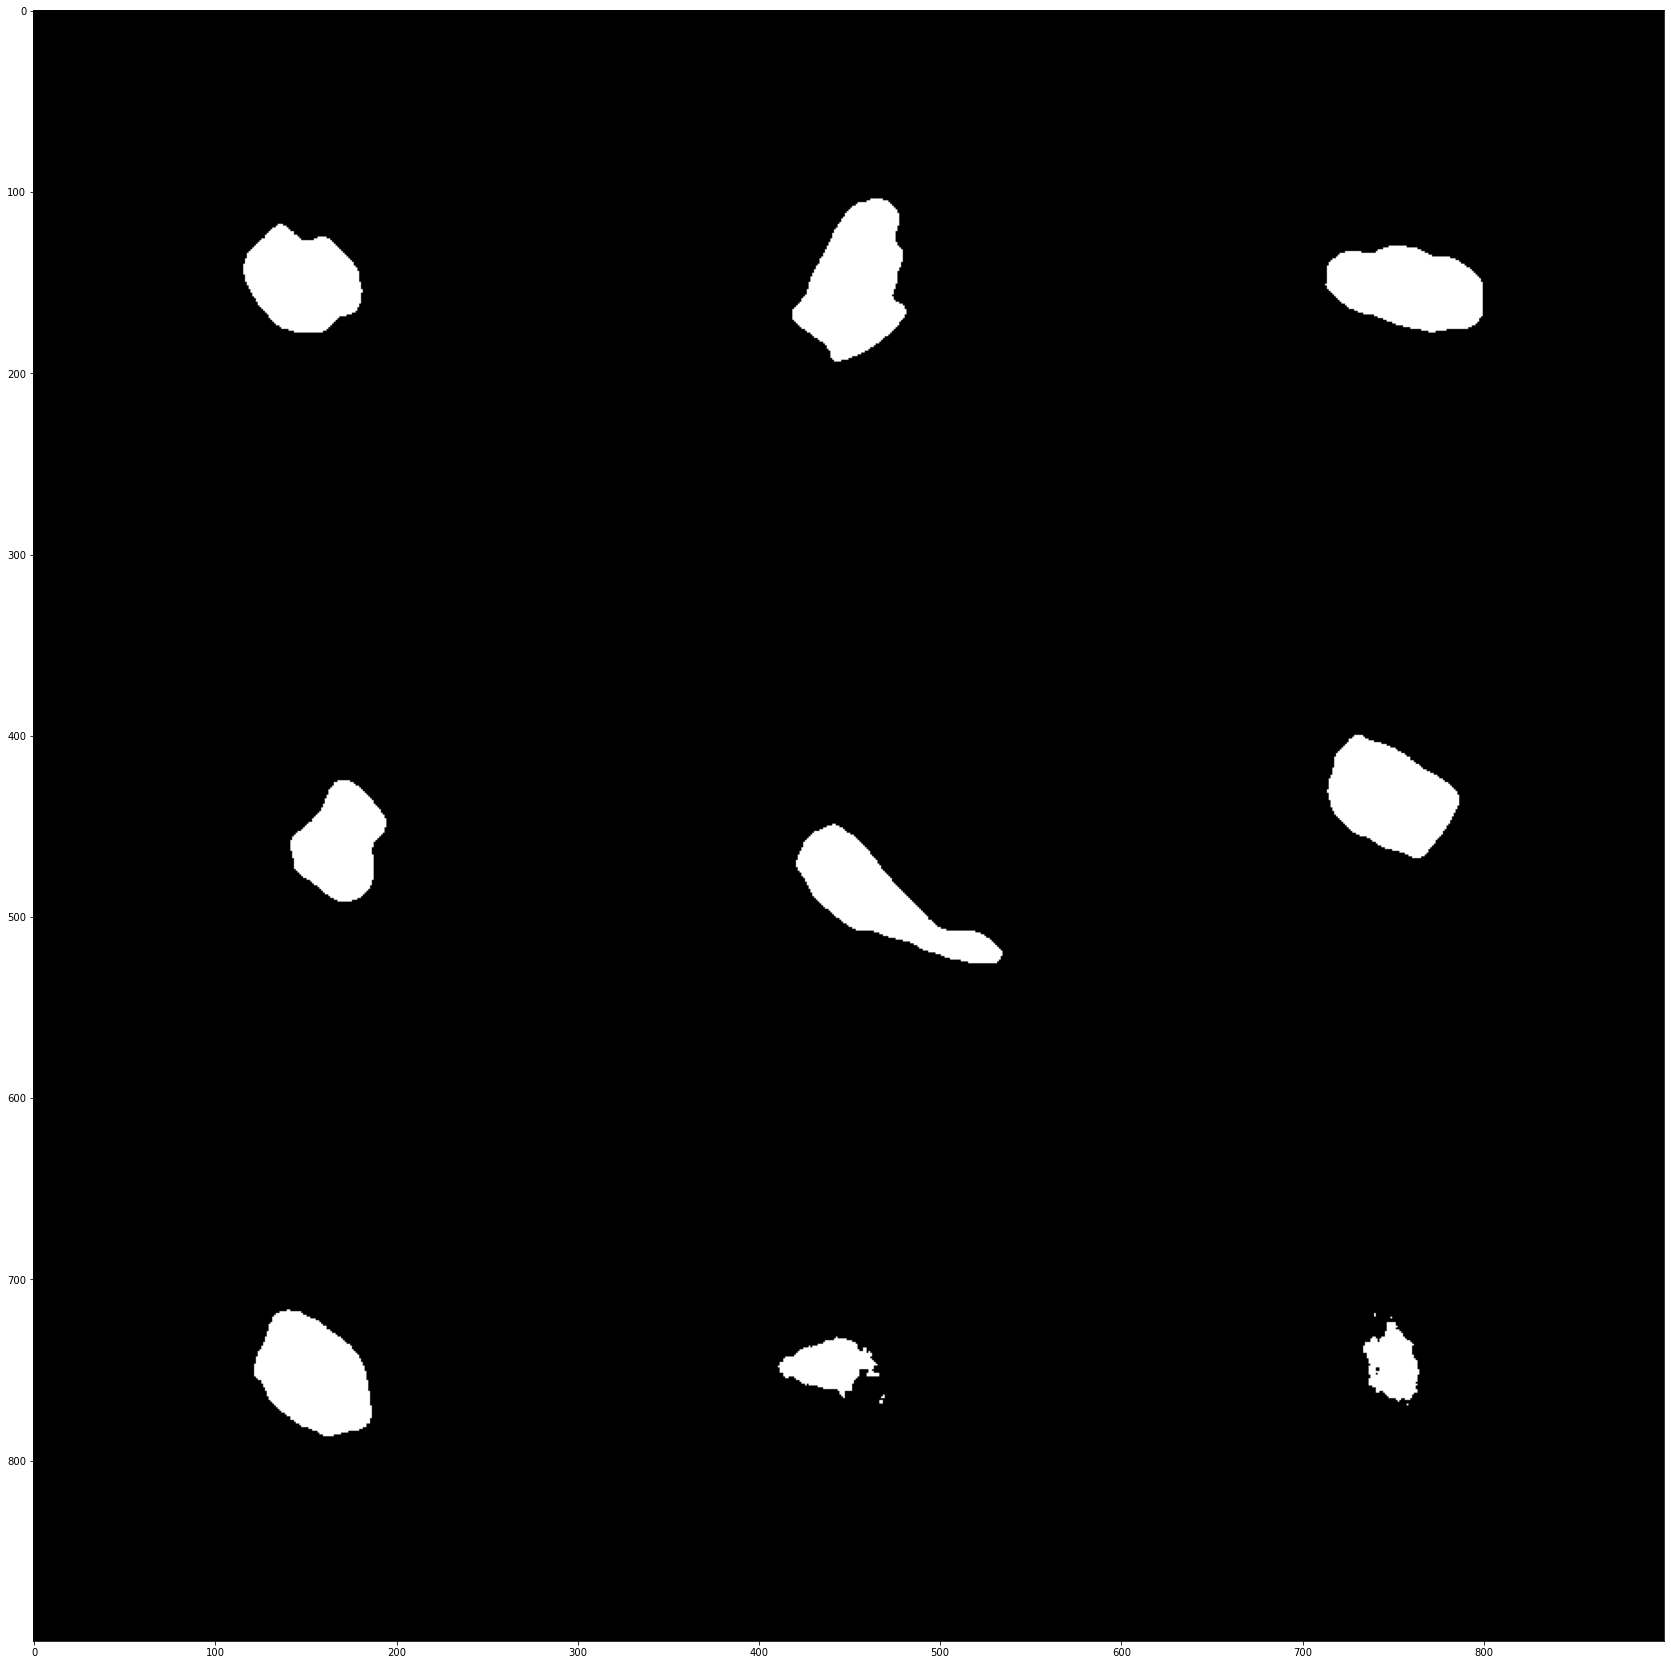

In [186]:
if(ctr_tuple):
    print('control soma segmented images')
    class_montage(soma_img[0:len(ctr_tuple)],40,30,rescale=False)
if(pos_tuple):
    print('disease soma segmented images')
    class_montage(soma_img[len(ctr_tuple):],40,30,rescale=False)

## Entire cell area
using gaussian blur and otsu threshold to capture the entire cell

*** Check this feature every time running dataset ***
Change parameters if necessary

- Should try to capture the entire cell, including neurites

Returns: 
* segmented images
* area of the entire cell

In [187]:
from imutils import contours
from skimage import measure
from skimage import exposure, morphology
from PIL import Image, ImageEnhance

def Gaussian_cell(data, plot_graph=True):
    cell_img, cell_area, filter_list = [], [], []

    for i in range(len(data)):
        numPixels = 0
        img = data[i][0].reshape(M,N)
        img2 = img.copy()
        
        # Apply adaptive histogram equalization if the image has low mean value
        if(np.mean(img) < 22500):
            img2 = exposure.equalize_adapthist(img2, clip_limit=0.015)
            gray = cv2.normalize(img2, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
            orig = gray.copy()
            blurred = cv2.GaussianBlur(gray, (9, 9), 0)
            upper, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        else:
            #No contrast done for rare cases
            gray = cv2.normalize(img2, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
            blur = cv2.medianBlur(gray, 9)
            kernel = np.ones((3,3), np.uint8)
            thresh_value = 105
            thresh = blur > thresh_value

        # Find the largest connected component
        labels = measure.label(thresh, connectivity=2, background=0)
        mask = np.zeros(thresh.shape, dtype="uint8")
        largestCC = labels == np.argmax(np.bincount(labels.flat, weights= thresh.flat))
        tmp_thresh = thresh.copy()

        # Remove regions with very low intensity if they have a brighter region nearby
        obj_int = np.mean(img2[np.nonzero(largestCC)])
        if (len(np.unique(labels)) > 1):
            if(obj_int < 0.4):
                tmp_thresh[largestCC] = 0
                largestCC2 = labels == np.argmax(np.bincount(labels.flat, weights= tmp_thresh.flat))
                tmp_int = np.mean(img2[np.nonzero(largestCC2)])
                if(tmp_int > obj_int):
                    thresh[largestCC] = 0
                    largestCC = labels == np.argmax(np.bincount(labels.flat, weights= thresh.flat))
            
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[largestCC] = 255
        mask = cv2.add(mask, labelMask)
        numPixels = cv2.countNonZero(mask)
        
        # Filter out small regions
        if(numPixels < 100):
            mask[largestCC] = 0  
            numPixels = 0
          
        if(plot_graph):
            show_3_plot(img, thresh, 'Initial Segmentation', mask, "Final Segmentation")
    
        # Account for ballooning cells
        np_mask = mask.copy()
        kernel = np.ones((11,11),np.uint8)
        dilation = cv2.dilate(np_mask,kernel,iterations = 1)
        erosion = cv2.erode(dilation,kernel,iterations = 2)
        contours, hierarchy = cv2.findContours(erosion,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        
        if hierarchy is not None:
            for c, h in zip(contours, hierarchy[0]):
                    # If there is at least one interior contour
                    if h[2] != -1:
                        # Make sure it's not the 'zero' contour
                        if h[0] == -1:
                            mask[largestCC] = 0  
                            numPixels = 0
                            filter_list.append(data[i][1])      
                                
        else:
            mask[largestCC] = 0  
            numPixels = 0
            filter_list.append(data[i][1])
    
        if(numPixels > 40000):
            mask[largestCC] = 0  
            numPixels = 0
            filter_list.append(data[i][1])
            
        cell_area.append(numPixels)
        cell_img.append(mask)
    return cell_img, cell_area, filter_list

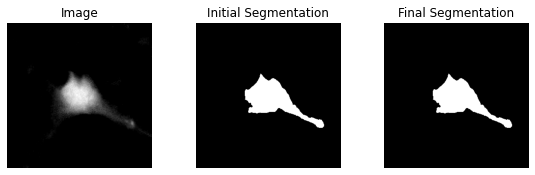

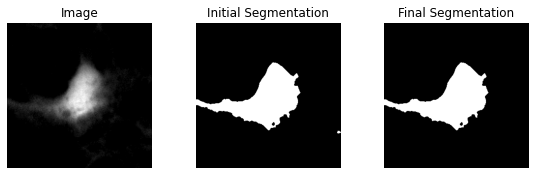

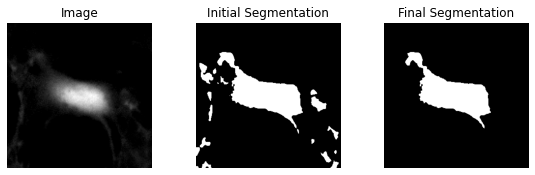

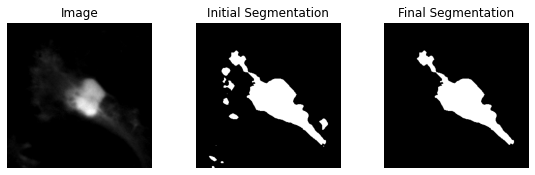

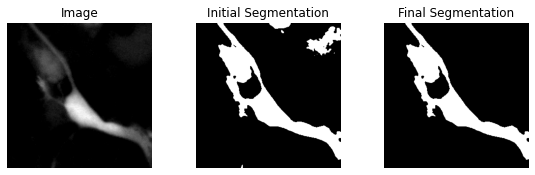

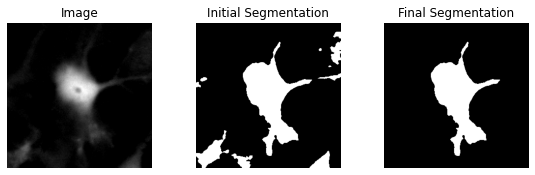

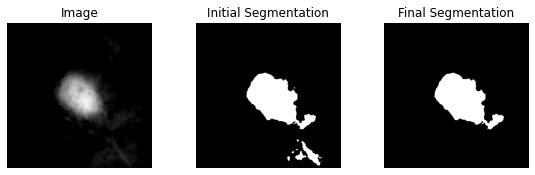

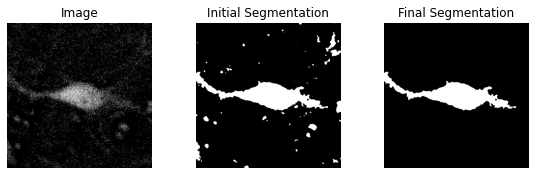

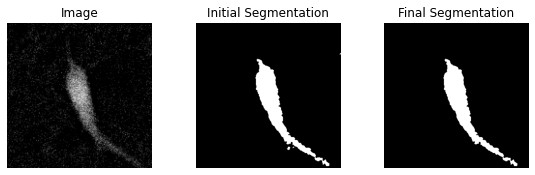

In [188]:
ctr_cell_img,ctr_cell_area,ctr_cell_area_filter = Gaussian_cell(ctr_tuple,plot_graph=True)
pos_cell_img,pos_cell_area,pos_cell_area_filter = Gaussian_cell(pos_tuple,plot_graph=True)

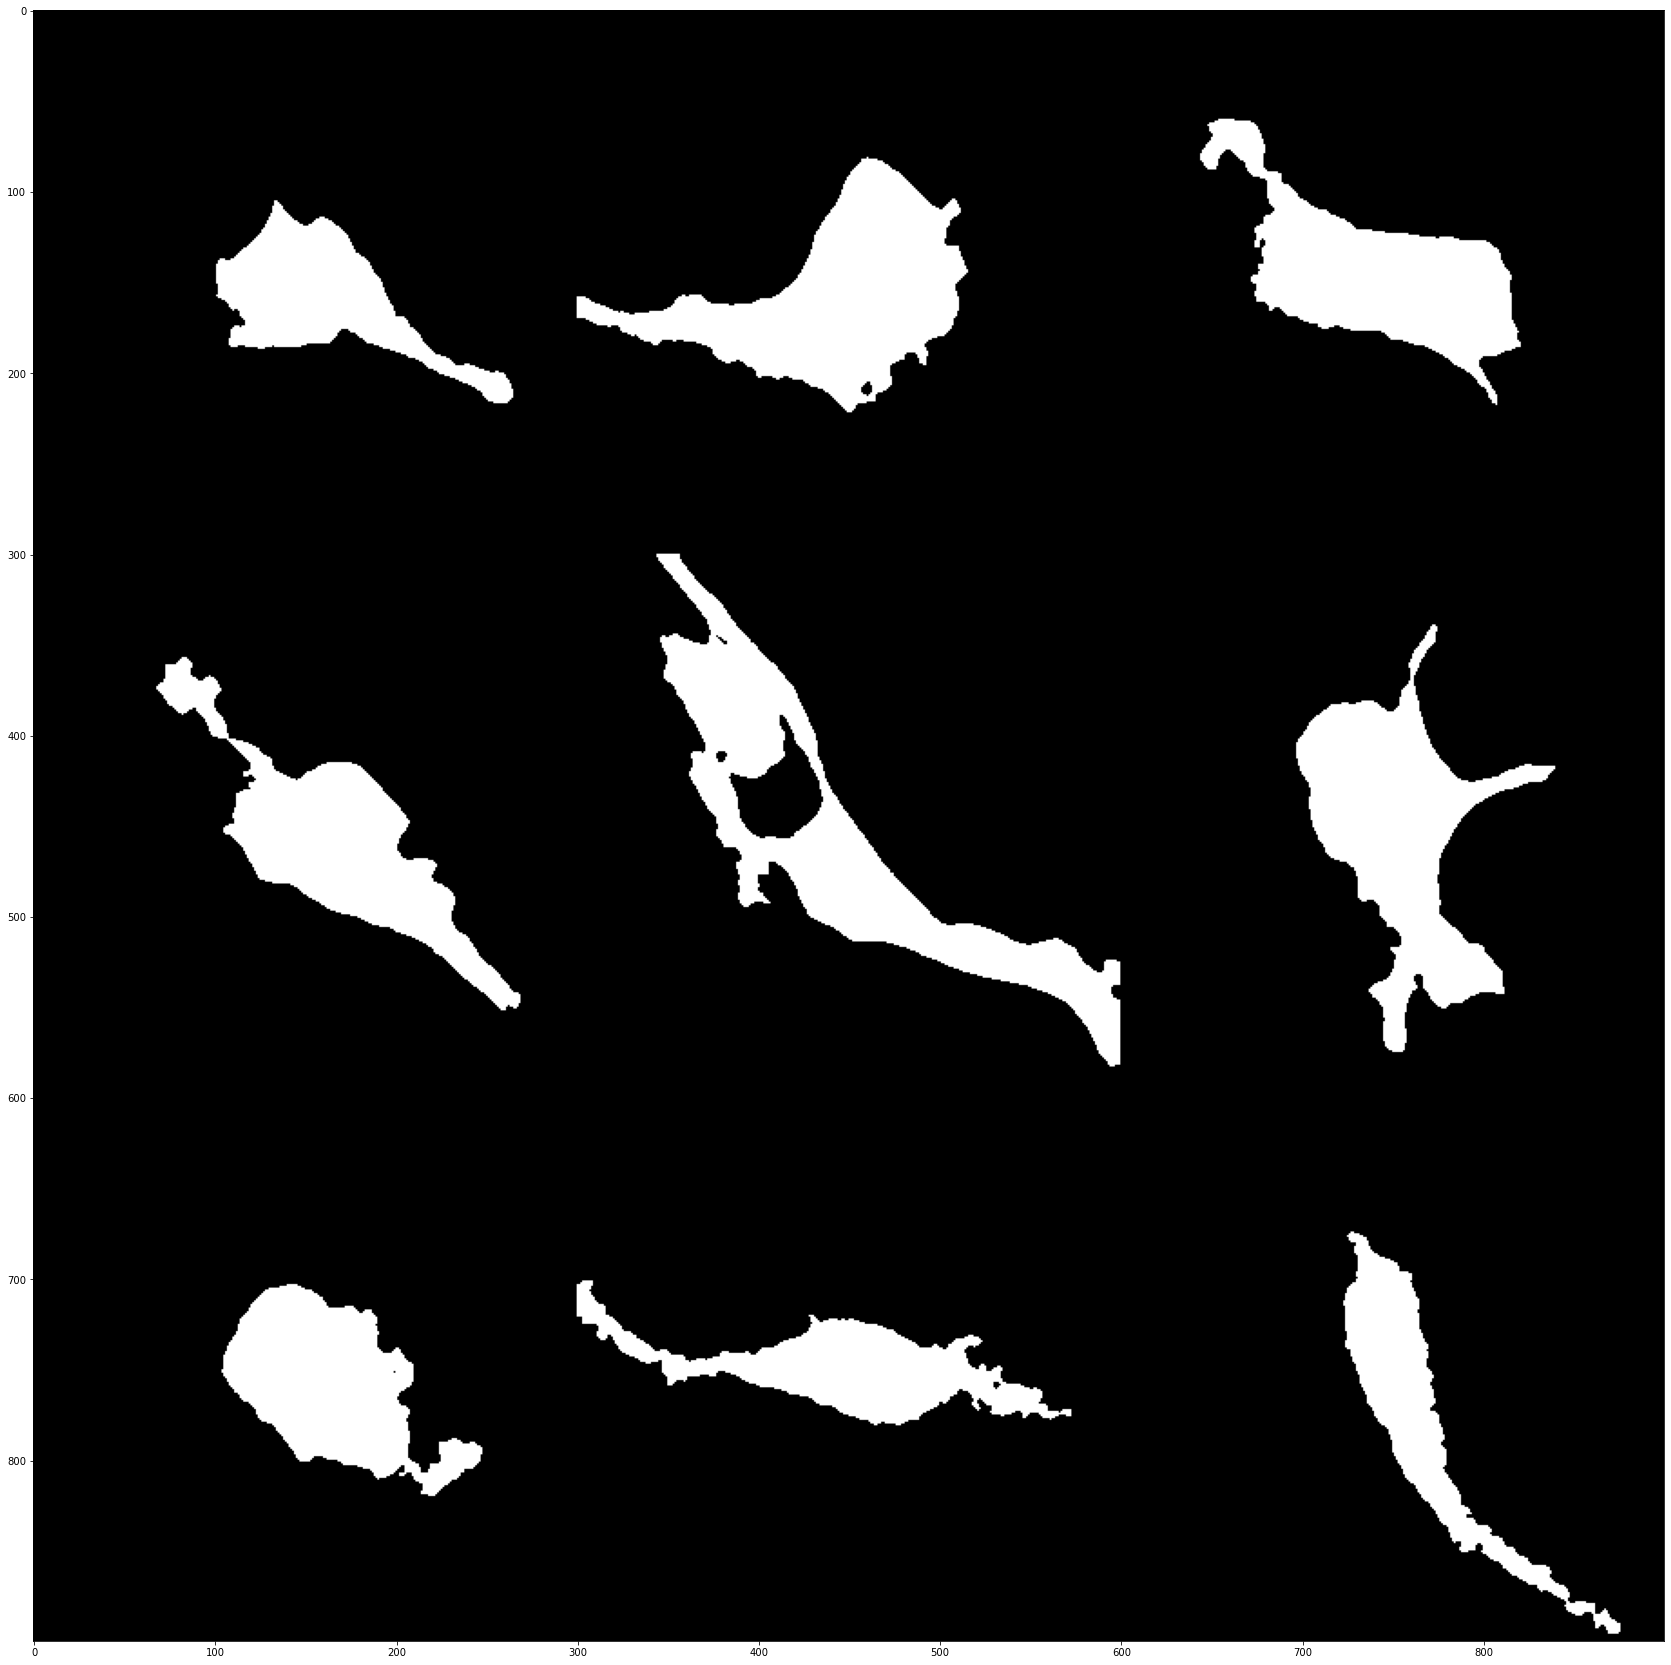

In [189]:
if(pos_cell_img):
    class_montage(pos_cell_img,40,30,rescale=False)
if(ctr_cell_img):
    class_montage(ctr_cell_img,40,30,rescale=False)

In [190]:
cell_area = pos_cell_area + ctr_cell_area

In [191]:
#combine all filtered images from soma feature + entire cell feature
filter_list_all = list(set(soma_filter_list + ctr_cell_area_filter + pos_cell_area_filter))
print('Number of total filtered images',len(filter_list_all))

Number of total filtered images 0


### Edge detection
Uses canny and dilation processes, RETR_TREE and simple approx. Masks are generated for objects passing threshold.
Returns:
* Count of detected contours
* Eccentricity of largest elliptical contour
* Area of largest elliptical contour
* Perimeter of largest elliptical contour

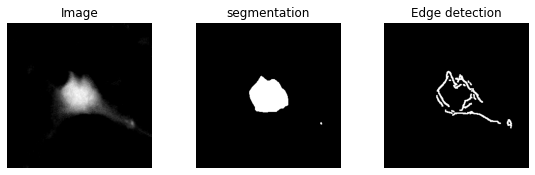

<ipython-input-195-04bc90763415>:42: RuntimeWarning: invalid value encountered in sqrt
  eccentricity = np.sqrt(1 - (a / b) ** 2)


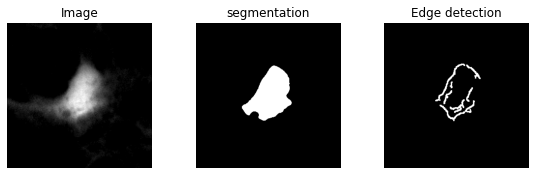

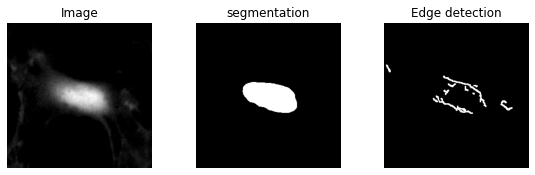

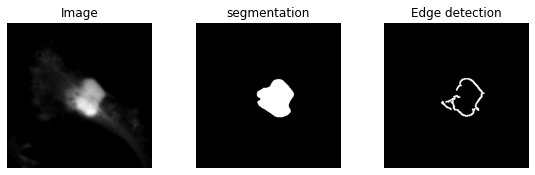

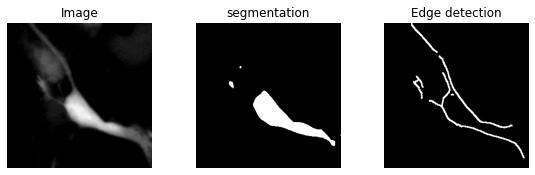

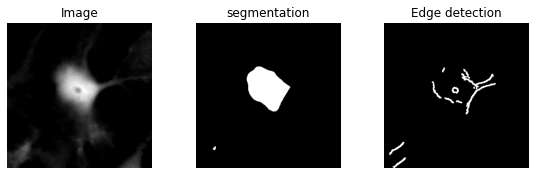

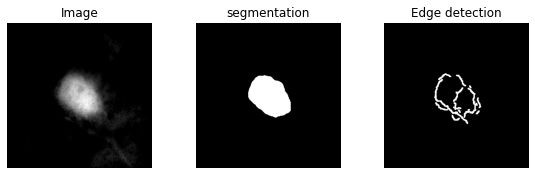

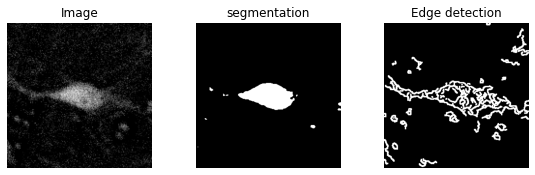

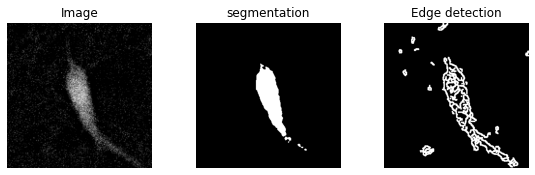

In [195]:
# FEATURE: edge detection

def edge_detection(data,plot_graph=True):
    final_cnts = []
    final_ecce = []

    for i in range(len(data)):
        img = data[i][0].reshape(M,N)
        gray = cv2.normalize(img, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)    
        blurred = cv2.GaussianBlur(gray,(11,11),0)

        upper, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        lower = 0.2 * upper

        edged = cv2.Canny(blurred, lower, upper)
        edged = cv2.dilate(edged, None, iterations=1)

        if(plot_graph):
            show_3_plot(img, thresh, "segmentation", edged, "Edge detection")

        # find contours in the edge map
        cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        
        temp_ecce = []
        temp_area = [] # Temporary list to store eccentricity and area values
        for cnt in cnts:
            if len(cnt) >= 5:
                ellipse = cv2.fitEllipse(cnt)
                cv2.ellipse(blurred, ellipse, (0, 255, 0), 2)

                # Center, axis lengths, and orientation of the ellipse
                (center, axes, orientation) = ellipse

                # Length of MAJOR and minor axis
                majoraxis_length = max(axes)
                minoraxis_length = min(axes)
                a = majoraxis_length
                b = minoraxis_length

                 # Eccentricity of the ellipse
                eccentricity = np.sqrt(1 - (a / b) ** 2)
                temp_ecce.append(eccentricity)
                

                # AREA
                area = a * b * math.pi
                temp_area.append(area)
                
        final_cnts.append(len(cnts))
        if(len(temp_area) >0):
            final_ecce.append(temp_ecce[temp_area.index(max(temp_area))])
        else:
            final_ecce.append(0)
    return final_cnts, final_ecce

edge_cnts, edge_ecce = edge_detection(combine, plot_graph=True)

## Sobel Filter
sobel filter computes an approximation of the gradient of an image intensity

Returns:
* Median of sobel filter values

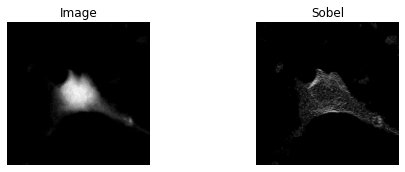

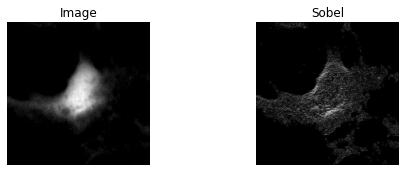

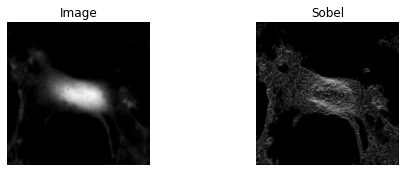

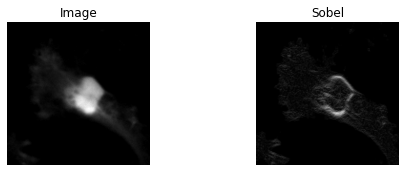

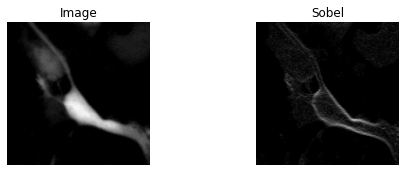

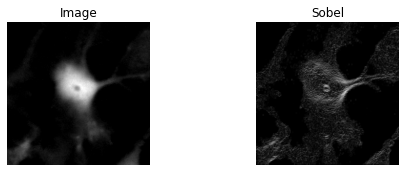

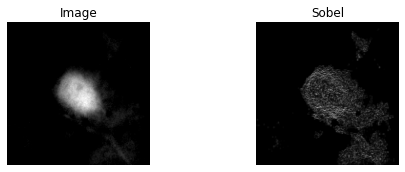

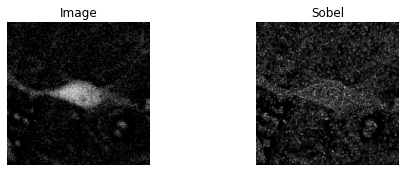

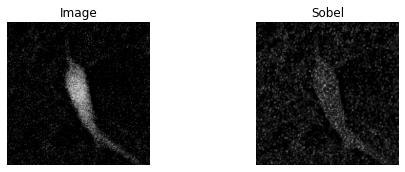

In [203]:
def sobel_filter(P):
    return (np.abs((P[0] + 2 * P[1] + P[2]) - (P[6] + 2 * P[7] + P[8])) +
            np.abs((P[2] + 2 * P[6] + P[7]) - (P[0] + 2 * P[3] + P[6])))

from scipy.ndimage.filters import generic_filter
    
def sobel_feature(data, plot_graph=True):
    sobel_medians = []

    for item in data:
        img = item[0].reshape(M, N)  # Reshape the image data
        G = generic_filter(img, sobel_filter, (3, 3))  # Apply Sobel filter
        sobel_medians.append(np.median(G))  # Calculate and store the median

        if plot_graph:
            show_2_plot(img, G, "Sobel")  # Optionally display the Sobel results

    return sobel_medians

# Call the sobel_feature function
sobel_med = sobel_feature(combine, plot_graph=True)

## Hog

- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
- gives the edge direction

Return:
* the mean of directions in an image

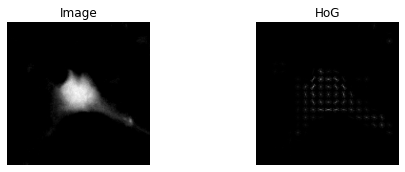

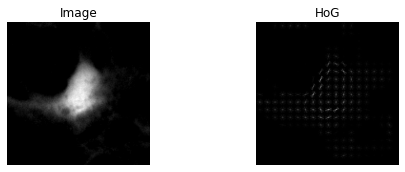

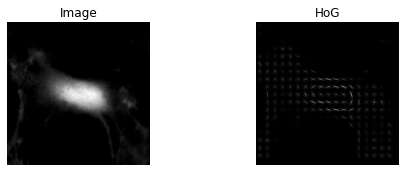

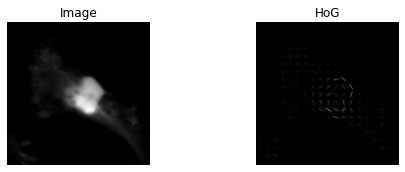

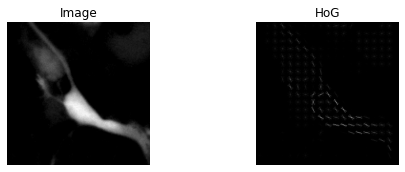

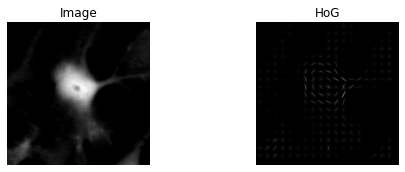

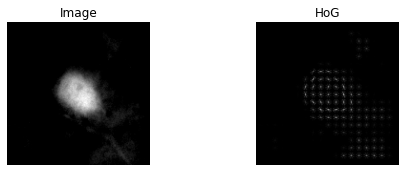

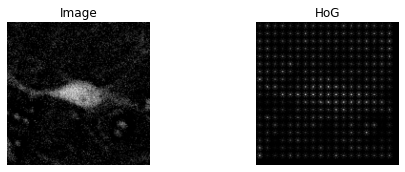

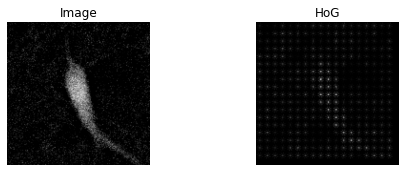

In [41]:
from skimage.feature import hog
def hog_filter(data, plot_graph=True):
    ppc = 16
    hog_images = []
    hog_features = []
    for i in range(len(data)):
        img = data[i][0].reshape(M,N)
        fd,hog_image = hog(img, orientations=8, pixels_per_cell=(ppc,ppc),cells_per_block=(3, 3),block_norm= 'L2',visualize=True)
    
        if(plot_graph):
            show_2_plot(img, hog_image,"HoG")

        hog_images.append(hog_image)
        hog_features.append(np.mean(fd))
    return hog_features

hog_features = hog_filter(combine, plot_graph=True)

## Sobel Noise

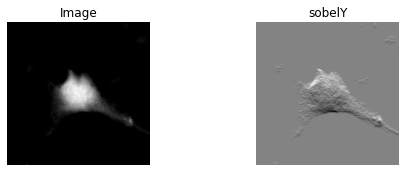

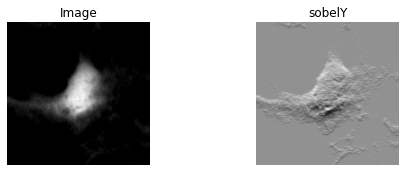

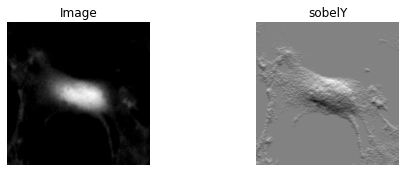

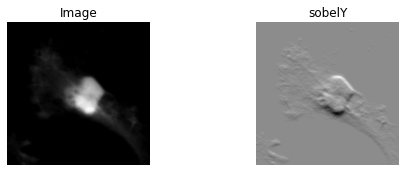

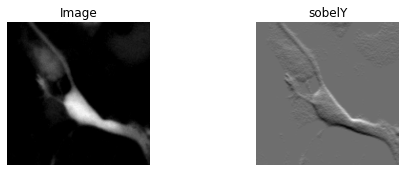

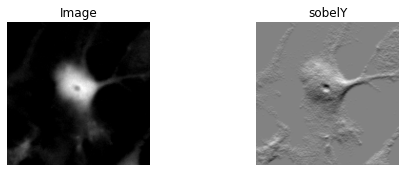

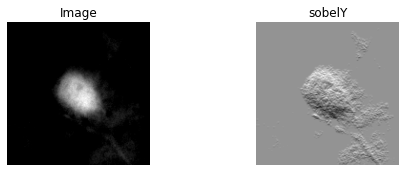

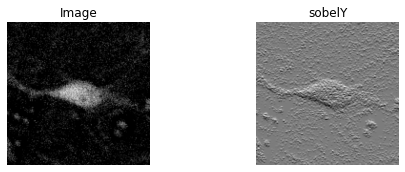

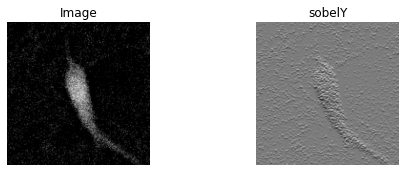

In [48]:
from skimage.filters import frangi, hessian
from scipy import signal
import math
# Evaluate noise in Hessian
def estimate_noise(I):
    H, W = I.shape
    M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
    sigma = np.sum(np.sum(np.absolute(signal.convolve2d(I, M))))
    sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
    return sigma


def sobel_noise(data,plot_graph=True):
    finalSobNoise = []
    for i in range(len(data)):
        img = data[i][0].reshape(M,N)
        gray = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
        
        if(plot_graph):
            show_2_plot(gray, sobely,"sobelY")
            
        finalSobNoise.append(estimate_noise(sobely))
        
    return finalSobNoise
     
finalSobNoise = sobel_noise(combine, plot_graph=True)

## Fourier Transform 
- find the frequency domain
- You can consider an image as a signal which is sampled in two directions. So taking fourier transform in both X and Y directions gives you the frequency representation of image.


https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html

<ipython-input-204-6bcd4a963099>:15: RuntimeWarning: divide by zero encountered in log
  imgMagnitude = 20*np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))


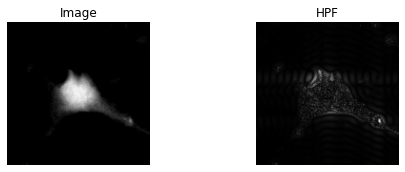

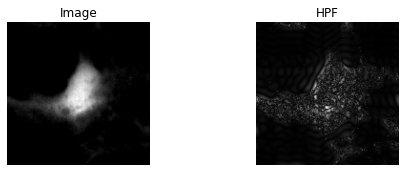

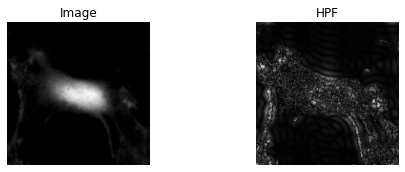

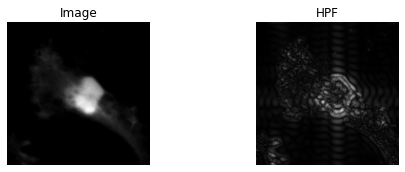

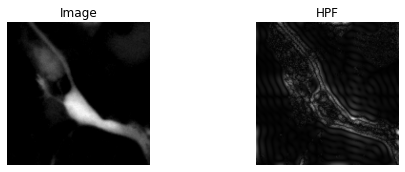

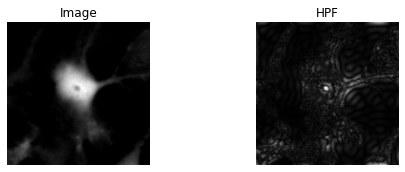

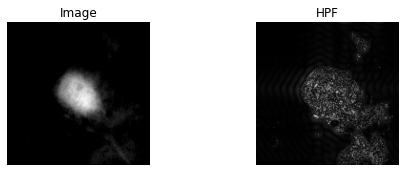

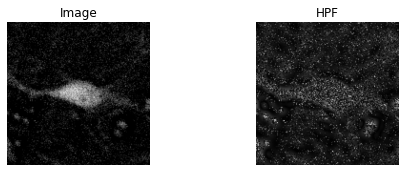

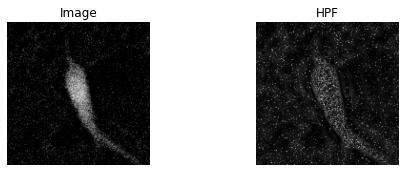

In [204]:
from PIL import Image, ImageStat
def fourier_transform(df, plot_graph=True):
    fft_hpf = []
    fft_power = []
    ffp_lpf = []

    for i in range(len(df)):
        img = df[i][0].reshape(M,N)
        gray = cv2.normalize(img, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
        
        # Perform the Discrete Fourier Transform (DFT)
        row, col = img.shape
        centerRow, centerCol = int(row/2), int(col/2)
        dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
        dft_shift = np.fft.fftshift(dft)
        imgMagnitude = 20*np.log(cv2.magnitude(dft_shift[:,:,0], dft_shift[:,:,1]))
        
        centerRectangle = 10
        # Apply high-pass filter
        dft_shift[centerRow - centerRectangle: centerRow + centerRectangle,
        centerCol - centerRectangle: centerCol + centerRectangle] = 0
        dft_i_shift = np.fft.ifftshift(dft_shift)
        img_back = cv2.idft(dft_i_shift)
        img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])
         # Calculate the median value of the high-pass filtered image
        median_img_back = np.median(img_back.ravel())
        fft_hpf.append(median_img_back)
        
        if(plot_graph):
            show_2_plot(gray, img_back,"HPF")
            
    return fft_hpf

fft_hpf = fourier_transform(combine, plot_graph=True)

## Sholl analysis
Sholl analysis is a method of quantitative analysis commonly used in neuronal studies to characterize the morphological characteristics of an imaged neuron

Return:
* Median of circle intercepts
* Median of total of circle intercepts

In [207]:
from fil_finder import FilFinder2D
import astropy.units as u
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from skimage.util import invert

def sholl_analysis(df,plot_graph=False):
    final_sholl_med = []
    final_sholl_total = []
    for i in range(len(df)):
        temp_per_circle = []
        Cnt = []
        count = 0
     
        # Preprocess the input image
        img = df[i][0].reshape(M, N)
        img = exposure.equalize_adapthist(img, clip_limit=0.01)
        gray = cv2.normalize(img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
        img_skel = gray.copy()

        # (3,3) radius
        img = cv2.GaussianBlur(img, (3, 3), 0)
        (_, _, _, maxLoc) = cv2.minMaxLoc(img)
        cv2.circle(img, maxLoc, 7, (255, 0, 0), 2)

        # Threshold the image
        img_skel = cv2.GaussianBlur(gray, (9, 9), 0)
        _, img_skel = cv2.threshold(img_skel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        # Step 1: Create an empty skeleton
        size = np.size(img_skel)
        skel = np.zeros(img_skel.shape, np.uint8)
        element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

        # Repeat steps 2-4
        while True:
            #Step 2: Open the image
            open = cv2.morphologyEx(img_skel, cv2.MORPH_OPEN, element)
            #Step 3: Substract open from the original image
            temp = cv2.subtract(img_skel, open)

            #Step 4: Erode the original image and refine the skeleton
            eroded = cv2.erode(img_skel, element)
            skel = cv2.bitwise_or(skel,temp)
            img_skel = eroded.copy()
            # Step 5: If there are no white pixels left ie.. the image has been completely eroded, quit the loop
            if cv2.countNonZero(img_skel)==0:
                break

        try:
            # get length of skeleton using fil_finder
            fil = FilFinder2D(skel,distance=250*u.pc, mask=skel)
            fil.create_mask(border_masking=False, verbose=False, use_existing_mask=True)
            fil.medskel(verbose=False)
            fil.analyze_skeletons(branch_thresh=40*u.pix, skel_thresh=1*u.pix, max_prune_iter=3)
    
            gray2 = cv2.GaussianBlur(gray, (7,7), 0)
            
            if(plot_graph):
                show_2_plot(gray, fil.skeleton,"Sholl Skeleton")
            
             # Perform edge detection
            upper, thresh = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            lower = 0.5*upper
            edged = cv2.Canny(gray, lower, upper)
            edged = cv2.dilate(edged, None, iterations=1)

            per_img_count = 0
            rad = 2
            step = 20
            offset = 0

            while rad < (img.shape[0] + step):
                per_circ_count = 0
                intercept_mode = False
                for t in range(offset, 360 + offset, 1):
                    angle = t * math.pi / 180
                    x = rad * math.cos(angle) + maxLoc[0]
                    y = rad * math.sin(angle) + maxLoc[1]

                    if (x >= 0 and x < skel.shape[0] and y >= 0 and y < skel.shape[1]):

                        if np.any(edged[math.floor(x),math.floor(y)] == 0) and intercept_mode==True:
                            intercept_mode = False
                        if intercept_mode== False:
                            if np.any(edged[math.floor(x),math.floor(y)] == 255):
                                per_circ_count += 1
                                intercept_mode = True
                            else:
                                pass
                        else:
                            pass

                rad += step
                if per_circ_count != 0:
                    per_circ_count = math.ceil(per_circ_count/2)
                    temp_per_circle.append(per_circ_count)
                    per_img_count += per_circ_count
                
        except Exception as e:
            print(f"No Sholl calculated: {e}")

        try:
            final_sholl_med.append(math.ceil(np.median(temp_per_circle)))
        except:
            final_sholl_med.append(0)
            
    return final_sholl_med

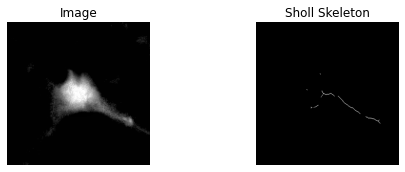

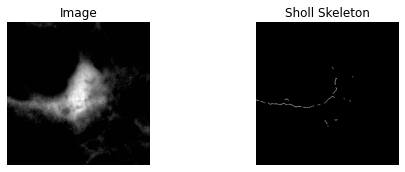

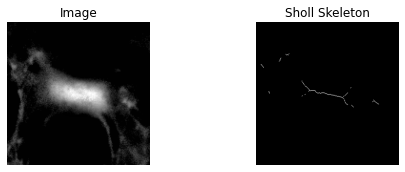

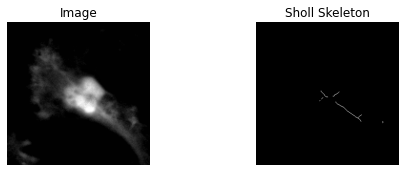

/opt/anaconda3/lib/python3.8/site-packages/fil_finder/length.py:282: RuntimeWarning: invalid value encountered in double_scalars
  w * (intensity[idx] / np.sum(intensity))


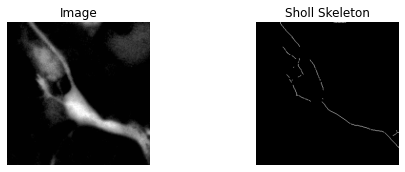

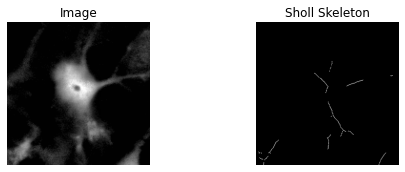

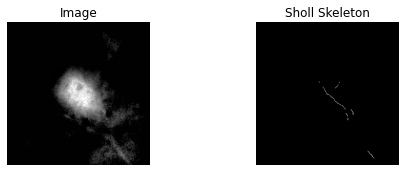

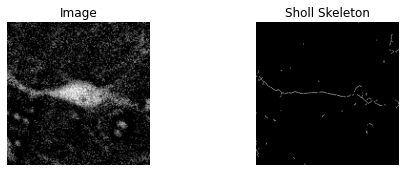

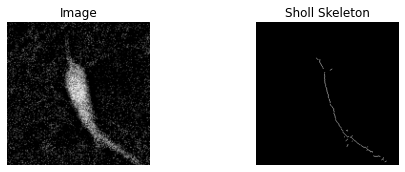

In [208]:
sholl_med = sholl_analysis(combine, plot_graph=True)

## Fractal of Minkowski Bouligand dimension
 Measures how complexity of detail changes with the scale at which one views the fractal
 The larger a fractal's Minkowski dimension, the more self-similar the fractal (fractal contains many constricted copies of itself)

In [91]:
def fractal_dimension(Z, threshold=50):
    # Only for 2d image
    assert(len(Z.shape) == 2)

    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # Count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])

    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]

def mink_boul_dim(df):
    
    finalMinkDim = []
    for i in range(len(df)):
        image = df[i][0].reshape(M,N)
        gray = cv2.normalize(image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
         sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
        finalMinkDim.append(fractal_dimension(sobely))
    return finalMinkDim

finalMinkDim = mink_boul_dim(combine)

## GLCM features
histogram of co-occurring greyscale values

- https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

- Dissimilarity (Difference Average) measures the mean of the gray level difference distribution of the image. A larger value implies greater disparity in intensity values among neighboring voxels.

- Correlation measures the linear dependency of gray levels on those of neighboring pixels or specified points. It indicates local gray-level dependency on the texture image; higher values can be obtained for similar gray-level regions.

- Joint Energy is a measure of homogeneity of an image. A homogeneous scene will contain only a few gray levels, so that GLCM will have a few but relatively high values of p(i, j). Thus, the sum of squares will be high. It is the monotonic gray-level transition; higher values indicate textural uniformity. Therefore, when the image is homogeneous, the Energy feature will have high values.




In [216]:
from skimage.feature import greycomatrix, greycoprops

def glcm_texture(df, plot_graph=True):
    glcm_dissimilarity = []
    glcm_correlation = []
    glcm_energy = []

    for i in range(len(df)):
        image = df[i][0].reshape(M, N)
        gray = cv2.normalize(image, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8UC1)
        glcm = greycomatrix(gray, distances=[3], angles=[0], levels=256,
                            symmetric=True, normed=True)

        dissimilarity = greycoprops(glcm, 'dissimilarity')[0, 0]
        correlation = greycoprops(glcm, 'correlation')[0, 0]
        energy = greycoprops(glcm, 'energy')[0, 0]

        glcm_dissimilarity.append(dissimilarity)
        glcm_correlation.append(correlation)
        glcm_energy.append(energy)

    return glcm_dissimilarity, glcm_correlation, glcm_energy

glcm_dissimilarity, glcm_correlation, glcm_energy = glcm_texture(combine, plot_graph=True)

## Haralick:

Haralick texture features are calculated from a Gray Level Co-occurrence Matrix, (GLCM),
a matrix that counts the co-occurrence of neighboring gray levels in the image.

------------------------Haralick Texture---------------------------


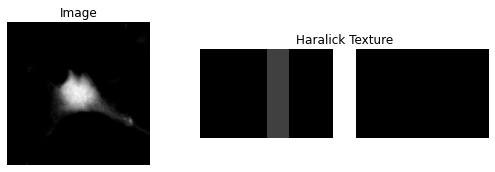

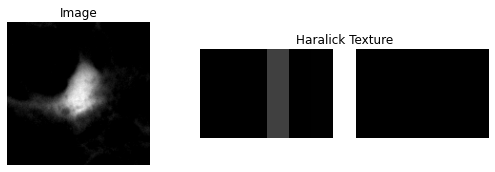

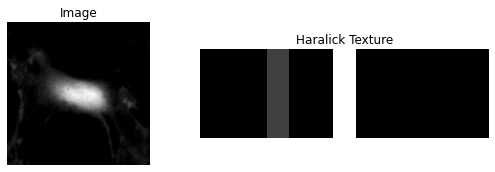

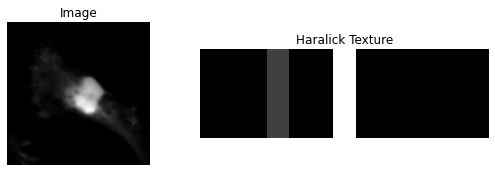

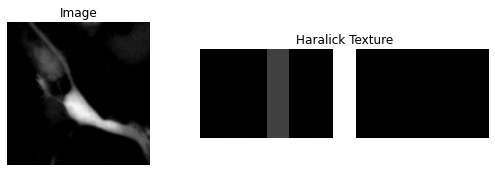

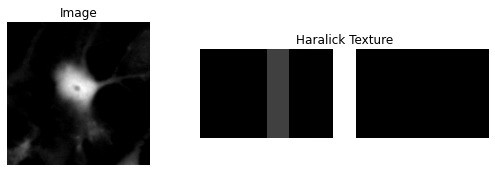

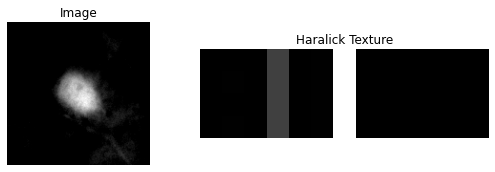

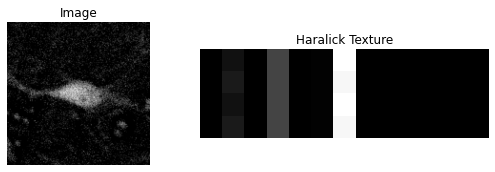

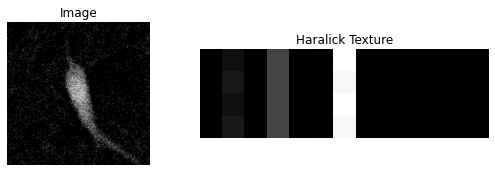

In [84]:
import mahotas as mt
def haralick_texture(df,plot_graph=True):
    
    ent = []
    for i in range(len(df)):
        image = df[i][0].reshape(M,N)
        gray = cv2.normalize(image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
        textures = mt.features.haralick(gray)
            
        ht_mean = textures.mean(axis=0)
        if(plot_graph):
            show_2_plot(gray, textures,"Haralick Texture")
            
        ent.append(np.mean(ht_mean))
    return ent

haralick = haralick_texture(combine)


## Sobel Operator 
Sobel Operator is trying to find out the amount of the difference by placing the gradient matrix over each pixel of our image. 

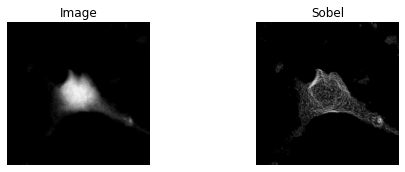

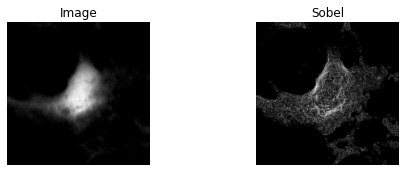

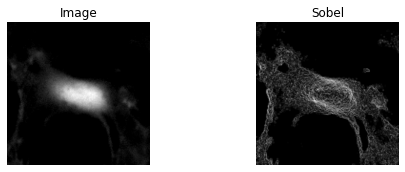

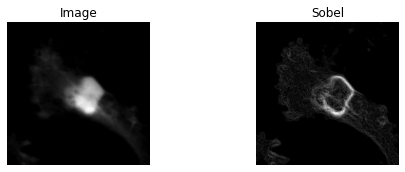

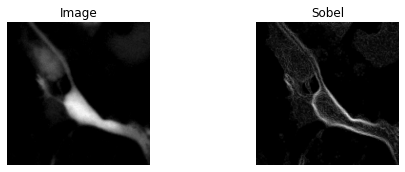

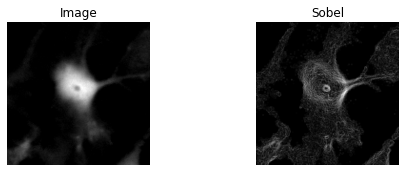

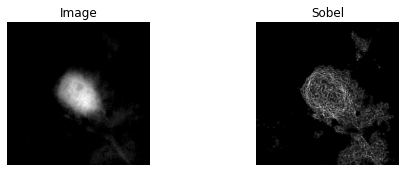

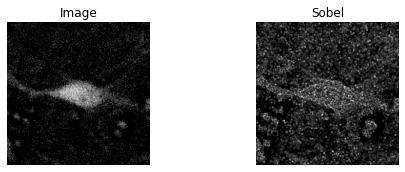

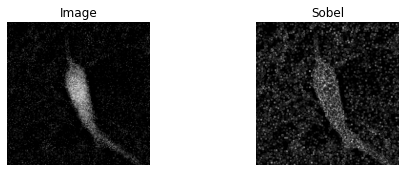

In [76]:
def sobel_feaure(df, plot_graph=False):
    finalLap = []
    finalSobel = []
    finalSobelx =[]
    finalSobely = []
    for i in range(len(df)):
        img = df[i][0].reshape(M,N)
        gray = cv2.normalize(img, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
        edges = skimage.filters.sobel(gray)
        finalSobel.append(np.mean(edges))

        if(plot_graph):
            show_2_plot(gray, edges,"Sobel")
    return finalSobel


finalSobel = sobel_feaure(combine, plot_graph=True)

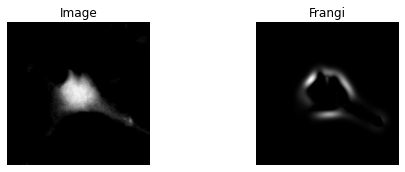

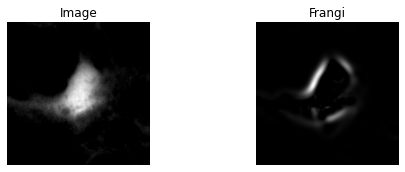

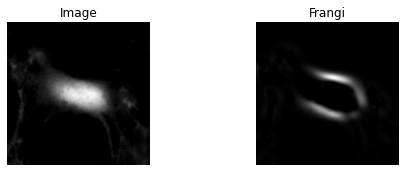

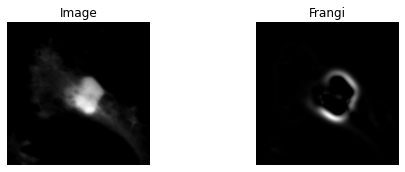

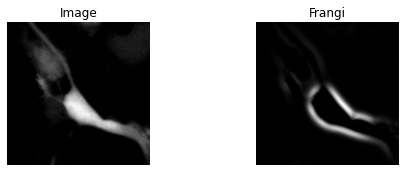

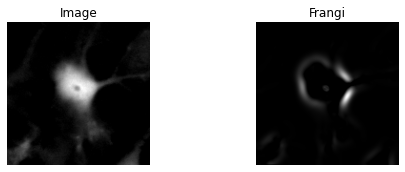

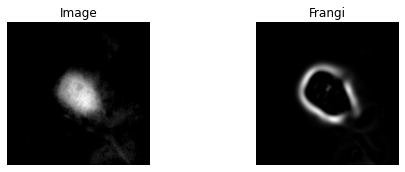

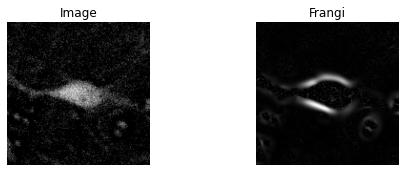

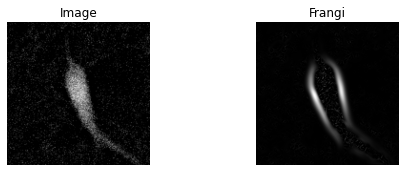

In [87]:
import mahotas as mt
import skimage.filters as sk_filt

def frangi(df,plot_graph=True):
    
    output = []
    for i in range(len(df)):
        image = df[i][0].reshape(M,N)
        gray = cv2.normalize(image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
        filt_im = sk_filt.frangi(gray,scale_range = (0,5))
        
        if(plot_graph):
            show_2_plot(gray, filt_im,"Frangi")
            
        output.append(np.median(filt_im))
    return output

frangi_output = frangi(combine, plot_graph=True)

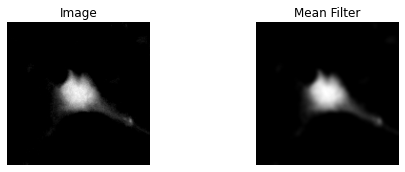

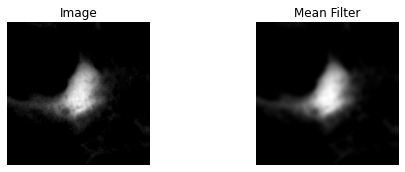

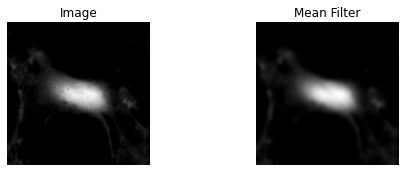

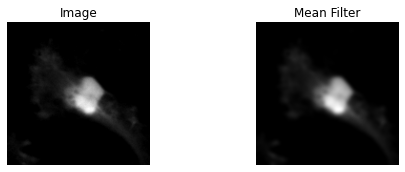

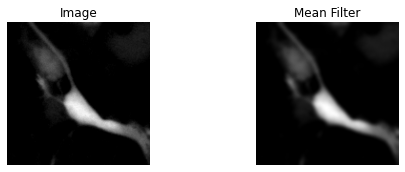

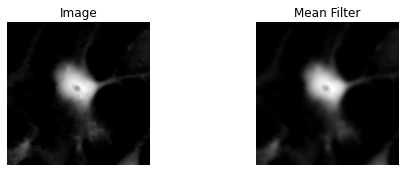

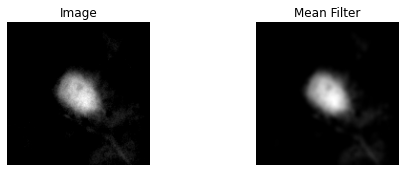

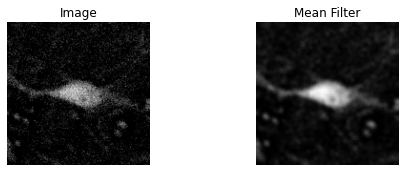

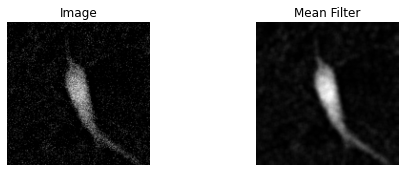

In [88]:
import mahotas as mt
import skimage.filters as sk_filt
from skimage.morphology import disk


import warnings
warnings.simplefilter("ignore", UserWarning)

def mean(df,plot_graph=True):
    
    output = []
    for i in range(len(df)):
        image = df[i][0].reshape(M,N)
        gray = cv2.normalize(image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)  
        filt_im = sk_filt.rank.mean(image,disk(5))
        
        if(plot_graph):
            show_2_plot(gray, filt_im,"Mean Filter")

        output.append(np.median(filt_im))
    return output

mean_output = mean(combine,plot_graph=True)

## Save data to csv

In [126]:
df = pd.DataFrame(list(zip([x[1] for x in combine],soma_med, soma_skew, soma_area,
                           cell_area, edge_cnts, edge_ecce, 
                           sobel_med, hog_features, finalSobNoise, 
                           fft_hpf, finalMinkDim, glcm_dissimilarity, glcm_correlation, glcm_energy, haralick,
                           finalSobel, frangi_output, mean_output, 
                            sholl_med, 
                           [x[2] for x in combine],[x[3] for x in combine],[x[4] for x in combine])),
               columns =['ident','soma med', 'soma skew', 'soma', 'cell area',
                         'edge','edge ecce','sobel median','hog','sob noise',
                         'fft hpf','MinkDim','glcm_disimilarity','glcm_corr','glcm_energy','Haralick',
                         'sobel','frangi','mean filter',
                         'sholl_med', 'classif','cellline','exp'])

In [127]:
print([print(len(i)) for i in [soma_med,soma_skew,soma_area,
                           cell_area,
                           edge_cnts, edge_ecce,
                           sobel_med,hog_features,finalSobNoise,
                           fft_hpf,fft_power ,finalMinkDim,glcm_x, glcm_y,glcm_eng,haralick,
                               finalSobel,frangi_output,mean_output,
                            sholl_med]])

9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [92]:
df[-df['ident'].isin(filter_list_all)].to_csv("Z://StephanieLam//Cortical//FeatureAnalysis//COR37-GEDI//ObjectCropsFilteredSorted//CS2518n2.csv",index=False)